**Assignment 3 **

**Weather Time Series Forcasting**

**Name**: Priyanka Veepuri

An illustration of temperature forecasting using data uploaded from Amazon Web Services (AWS) and implemented with the Keras

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-09 01:02:28--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.28.54, 52.216.249.190, 52.216.42.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.28.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  40.6MB/s    in 0.3s    

2024-04-09 01:02:29 (40.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Examining the Jena weather dataset, which consists of 420,451 rows and includes 15 features.

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
 data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

number_var= len(header)
number_rows= len(lines)
print("Number of variables:",number_var)
print("Number of rows:",number_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Parsing the data

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
 values = [float(x) for x in line.split(",")[1:]]
 temperature[i] = values[1]
 raw_data[i, :] = values[:]

Plotting the temperature timeseries

Text(0, 0.5, 'Temp')

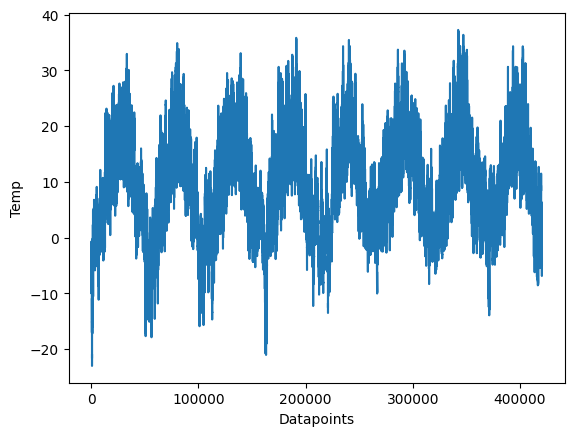

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Datapoints')
plt.ylabel('Temp')

 Plotting the first 10 days of the temperature timeseries

Text(0, 0.5, 'Temp')

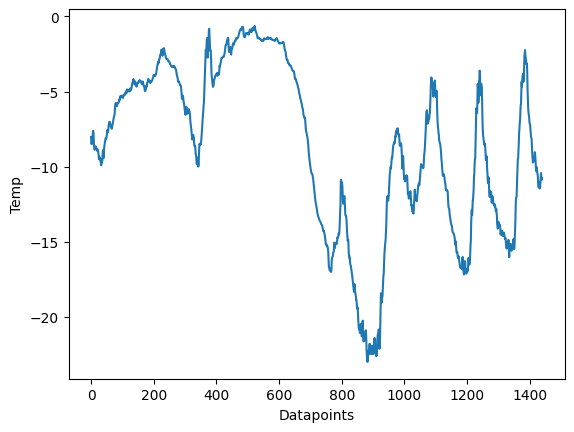

In [7]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Datapoints')
plt.ylabel('Temp')

 Computing the number of samples we’ll use for each data split

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalizing the data

Since the data is already in numbers, we don't need to convert it into vectors. However, because the values vary across different variables - for instance, temperature ranges from -20 to +30 and pressure is measured in millibars - it's a good idea to adjust all the variables so they're on the same scale.

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [14]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing

In [15]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

Inspecting the output of one of our datasets

In [16]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Computing the common-sense baseline MAE
Model-1

In [17]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


 Training and evaluating a densely connected model
 A basic machine-learning model
 Model2

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 57s 69ms/step - loss: 15.3777 - mae: 3.0229 - val_loss: 11.2130 - val_mae: 2.6394
Epoch 2/10
819/819 [==============================] - 57s 69ms/step - loss: 9.9405 - mae: 2.4849 - val_loss: 12.4296 - val_mae: 2.8054
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 8.9357 - mae: 2.3535 - val_loss: 10.6793 - val_mae: 2.5797
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 8.3474 - mae: 2.2752 - val_loss: 11.4340 - val_mae: 2.6821
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 7.9824 - mae: 2.2241 - val_loss: 11.3807 - val_mae: 2.6754
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 7.6691 - mae: 2.1843 - val_loss: 11.5243 - val_mae: 2.6846
Epoch 7/10
819/819 [==============================] - 53s 64ms/step - loss: 7.4440 - mae: 2.1513 - val_loss: 11.2124 - val_mae: 2.6618
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 35ms/step - loss: 11.8813 - mae: 2.6949
Test MAE: 2.69


<ipython-input-28-cfa89b244b5a>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey",  label="Training MAE")
<ipython-input-28-cfa89b244b5a>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


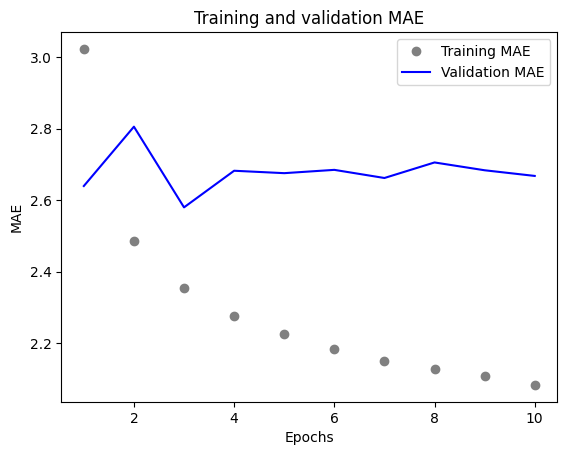

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey",  label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Trying a 1D convolutional model-
MODEL3

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_conv.keras",
 save_best_only=True)
]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 84s 102ms/step - loss: 22.4634 - mae: 3.7083 - val_loss: 14.7951 - val_mae: 3.0437
Epoch 2/10
819/819 [==============================] - 83s 101ms/step - loss: 15.5296 - mae: 3.1263 - val_loss: 14.6025 - val_mae: 3.0115
Epoch 3/10
819/819 [==============================] - 85s 103ms/step - loss: 14.5164 - mae: 3.0202 - val_loss: 16.0588 - val_mae: 3.1499
Epoch 4/10
819/819 [==============================] - 85s 104ms/step - loss: 13.7600 - mae: 2.9375 - val_loss: 14.2048 - val_mae: 2.9540
Epoch 5/10
819/819 [==============================] - 87s 106ms/step - loss: 13.1391 - mae: 2.8661 - val_loss: 14.4733 - val_mae: 2.9721
Epoch 6/10
819/819 [==============================] - 89s 108ms/step - loss: 12.5348 - mae: 2.7993 - val_loss: 14.9448 - val_mae: 3.0319
Epoch 7/10
819/819 [==============================] - 80s 97ms/step - loss: 12.0039 - mae: 2.7370 - val_loss: 13.4045 - val_mae: 2.8696
Epoch 8/10
819/819 [======================

In [ ]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 22s 53ms/step - loss: 14.1890 - mae: 2.9746
Test MAE: 2.97


<ipython-input-42-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-42-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


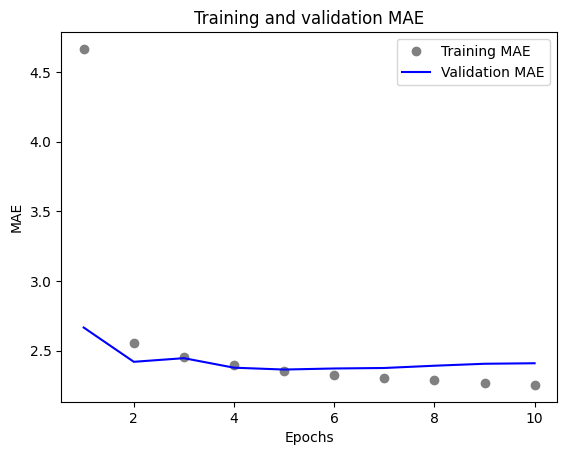

In [42]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM(Long Short-Term Memory )

LSTM-Simple MODEL4


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 121s 145ms/step - loss: 43.8655 - mae: 4.8444 - val_loss: 12.6865 - val_mae: 2.6963
Epoch 2/10
819/819 [==============================] - 118s 144ms/step - loss: 11.2731 - mae: 2.5976 - val_loss: 9.8465 - val_mae: 2.4458
Epoch 3/10
819/819 [==============================] - 119s 146ms/step - loss: 9.8582 - mae: 2.4440 - val_loss: 9.7021 - val_mae: 2.4132
Epoch 4/10
819/819 [==============================] - 101s 123ms/step - loss: 9.4103 - mae: 2.3857 - val_loss: 9.5589 - val_mae: 2.3977
Epoch 5/10
819/819 [==============================] - 101s 123ms/step - loss: 9.1151 - mae: 2.3500 - val_loss: 9.4907 - val_mae: 2.3895
Epoch 6/10
819/819 [==============================] - 101s 123ms/step - loss: 8.8943 - mae: 2.3197 - val_loss: 9.5183 - val_mae: 2.3803
Epoch 7/10
819/819 [==============================] - 120s 146ms/step - loss: 8.7252 - mae: 2.2982 - val_loss: 9.7407 - val_mae: 2.4159
Epoch 8/10
819/819 [=========================

In [ ]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 25s 59ms/step - loss: 10.9020 - mae: 2.5919
Test MAE: 2.59


<ipython-input-42-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-42-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


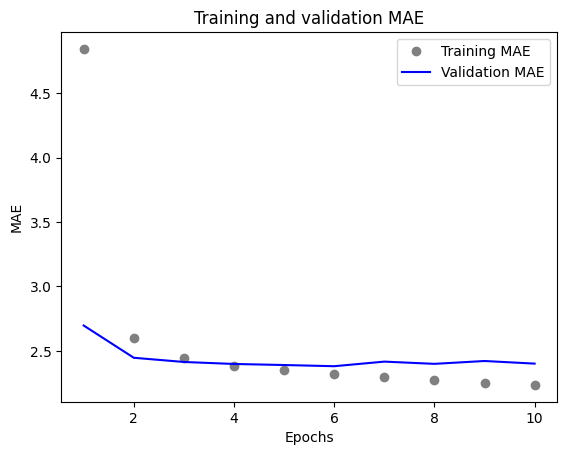

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - dropout Regularization MODEL5

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 177s 211ms/step - loss: 55.8456 - mae: 5.5872 - val_loss: 15.4951 - val_mae: 2.9459
Epoch 2/10
819/819 [==============================] - 173s 211ms/step - loss: 20.4489 - mae: 3.4662 - val_loss: 10.0078 - val_mae: 2.4502
Epoch 3/10
819/819 [==============================] - 156s 190ms/step - loss: 18.3789 - mae: 3.3011 - val_loss: 9.5541 - val_mae: 2.4102
Epoch 4/10
819/819 [==============================] - 175s 213ms/step - loss: 17.5950 - mae: 3.2278 - val_loss: 9.5074 - val_mae: 2.4134
Epoch 5/10
819/819 [==============================] - 187s 229ms/step - loss: 16.9643 - mae: 3.1725 - val_loss: 9.3533 - val_mae: 2.3947
Epoch 6/10
819/819 [==============================] - 181s 221ms/step - loss: 16.5368 - mae: 3.1323 - val_loss: 9.3467 - val_mae: 2.3960
Epoch 7/10
819/819 [==============================] - 173s 211ms/step - loss: 15.8036 - mae: 3.0670 - val_loss: 9.3751 - val_mae: 2.3877
Epoch 9/10
819/819 [===================

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 36s 84ms/step - loss: 10.3886 - mae: 2.5234
Test MAE: 2.52


<ipython-input-48-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-48-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


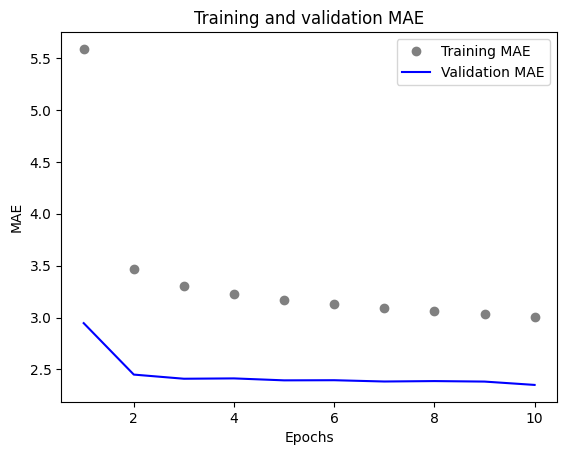

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - Stacked setup with 16 units MODEL6

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 203s 242ms/step - loss: 44.2751 - mae: 4.8575 - val_loss: 13.7097 - val_mae: 2.7942
Epoch 2/10
819/819 [==============================] - 201s 245ms/step - loss: 10.7125 - mae: 2.5404 - val_loss: 9.8772 - val_mae: 2.4426
Epoch 3/10
819/819 [==============================] - 185s 225ms/step - loss: 9.1742 - mae: 2.3686 - val_loss: 9.8954 - val_mae: 2.4468
Epoch 4/10
819/819 [==============================] - 169s 206ms/step - loss: 8.6387 - mae: 2.2969 - val_loss: 10.0186 - val_mae: 2.4550
Epoch 5/10
819/819 [==============================] - 179s 218ms/step - loss: 8.2075 - mae: 2.2375 - val_loss: 10.2918 - val_mae: 2.4991
Epoch 6/10
819/819 [==============================] - 177s 216ms/step - loss: 7.7231 - mae: 2.1729 - val_loss: 10.3445 - val_mae: 2.4999
Epoch 7/10
819/819 [==============================] - 175s 213ms/step - loss: 7.2850 - mae: 2.1078 - val_loss: 10.3319 - val_mae: 2.5051
Epoch 8/10
819/819 [=====================

In [ ]:
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 37s 86ms/step - loss: 10.7757 - mae: 2.5586
Test MAE: 2.56


<ipython-input-55-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-55-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


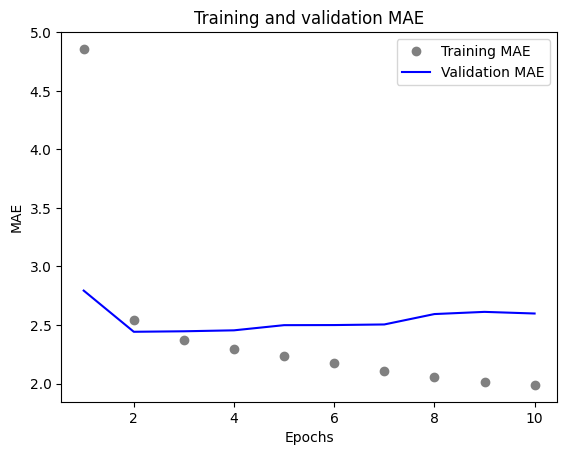

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - Stacked setup with 8 units MODEL7

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]

In [21]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [22]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 168s 201ms/step - loss: 68.8640 - mae: 6.3622 - val_loss: 35.3612 - val_mae: 4.4358
Epoch 2/10
819/819 [==============================] - 155s 189ms/step - loss: 21.3947 - mae: 3.4223 - val_loss: 13.2464 - val_mae: 2.7311
Epoch 3/10
819/819 [==============================] - 155s 189ms/step - loss: 11.4381 - mae: 2.6164 - val_loss: 9.5826 - val_mae: 2.3990
Epoch 4/10
819/819 [==============================] - 155s 188ms/step - loss: 10.1290 - mae: 2.4794 - val_loss: 9.3768 - val_mae: 2.3781
Epoch 5/10
819/819 [==============================] - 142s 173ms/step - loss: 9.7804 - mae: 2.4349 - val_loss: 9.0826 - val_mae: 2.3445
Epoch 6/10
819/819 [==============================] - 155s 188ms/step - loss: 9.5599 - mae: 2.4056 - val_loss: 9.1880 - val_mae: 2.3577
Epoch 7/10
819/819 [==============================] - 141s 172ms/step - loss: 9.3626 - mae: 2.3799 - val_loss: 8.9352 - val_mae: 2.3218
Epoch 8/10
819/819 [======================

In [25]:
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 38s 86ms/step - loss: 10.3631 - mae: 2.5302
Test MAE: 2.53


<ipython-input-26-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-26-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


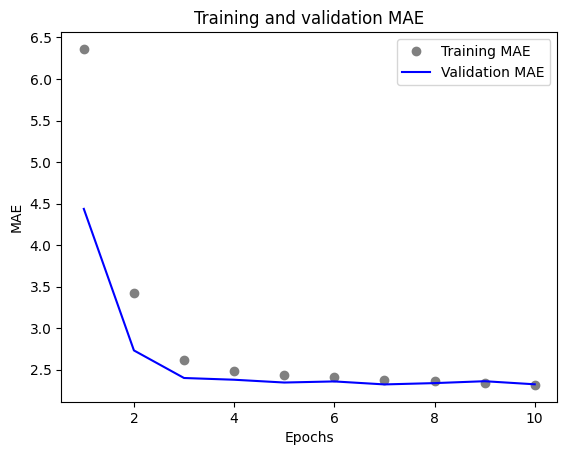

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - dropout-regularized MODEL8

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]

In [29]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 293s 350ms/step - loss: 74.9205 - mae: 6.6492 - val_loss: 35.7620 - val_mae: 4.4415
Epoch 2/10
819/819 [==============================] - 248s 302ms/step - loss: 31.8447 - mae: 4.2129 - val_loss: 14.3749 - val_mae: 2.8414
Epoch 3/10
819/819 [==============================] - 246s 300ms/step - loss: 24.3180 - mae: 3.7307 - val_loss: 11.1097 - val_mae: 2.5644
Epoch 4/10
819/819 [==============================] - 247s 301ms/step - loss: 22.3546 - mae: 3.5876 - val_loss: 10.1288 - val_mae: 2.4583
Epoch 5/10
819/819 [==============================] - 245s 299ms/step - loss: 21.2199 - mae: 3.4959 - val_loss: 9.9482 - val_mae: 2.4440
Epoch 6/10
819/819 [==============================] - 259s 316ms/step - loss: 20.0426 - mae: 3.3998 - val_loss: 9.6930 - val_mae: 2.4140
Epoch 7/10
819/819 [==============================] - 245s 298ms/step - loss: 19.2250 - mae: 3.3388 - val_loss: 9.3690 - val_mae: 2.3716
Epoch 8/10
819/819 [=================

In [30]:
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 33s 78ms/step - loss: 9.8499 - mae: 2.4497
Test MAE: 2.45


<ipython-input-31-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-31-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


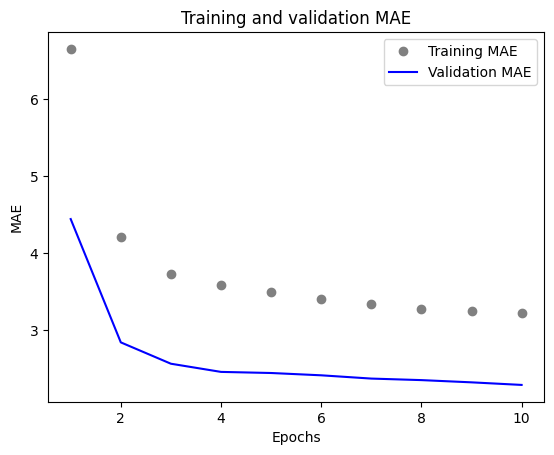

In [31]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectionl- MODEL9

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)



callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 169s 199ms/step - loss: 24.8170 - mae: 3.5866 - val_loss: 9.9907 - val_mae: 2.4497
Epoch 2/10
819/819 [==============================] - 163s 199ms/step - loss: 9.5308 - mae: 2.3991 - val_loss: 9.9041 - val_mae: 2.4007
Epoch 3/10
819/819 [==============================] - 153s 186ms/step - loss: 8.7166 - mae: 2.2938 - val_loss: 9.8110 - val_mae: 2.3925
Epoch 4/10
819/819 [==============================] - 166s 203ms/step - loss: 8.1562 - mae: 2.2211 - val_loss: 10.0294 - val_mae: 2.4059
Epoch 5/10
819/819 [==============================] - 153s 186ms/step - loss: 7.7236 - mae: 2.1612 - val_loss: 10.2567 - val_mae: 2.4400
Epoch 6/10
819/819 [==============================] - 158s 193ms/step - loss: 7.4375 - mae: 2.1198 - val_loss: 10.3196 - val_mae: 2.4547
Epoch 7/10
819/819 [==============================] - 163s 199ms/step - loss: 7.1448 - mae: 2.0796 - val_loss: 10.7829 - val_mae: 2.5110
Epoch 8/10
819/819 [=======================

<ipython-input-36-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-36-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


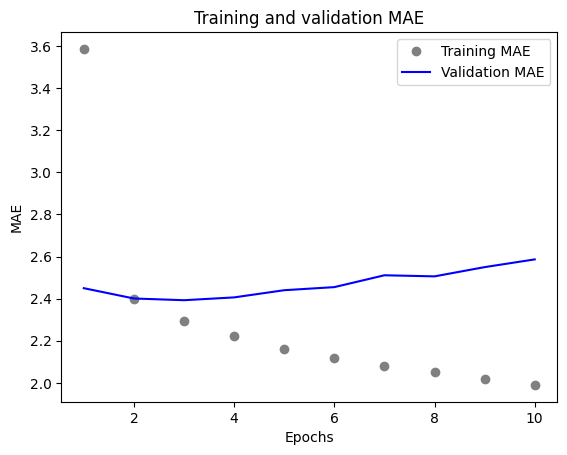

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnet and LSTM-MODEL10

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 117s 140ms/step - loss: 53.6767 - mae: 5.4980 - val_loss: 27.3972 - val_mae: 4.0389
Epoch 2/10
819/819 [==============================] - 113s 137ms/step - loss: 18.1557 - mae: 3.2820 - val_loss: 24.6813 - val_mae: 3.8861
Epoch 3/10
819/819 [==============================] - 115s 140ms/step - loss: 14.6340 - mae: 2.9716 - val_loss: 24.3232 - val_mae: 3.8744
Epoch 4/10
819/819 [==============================] - 112s 136ms/step - loss: 12.8693 - mae: 2.7816 - val_loss: 21.6502 - val_mae: 3.7087
Epoch 5/10
819/819 [==============================] - 134s 163ms/step - loss: 11.7443 - mae: 2.6508 - val_loss: 21.8076 - val_mae: 3.7634
Epoch 6/10
819/819 [==============================] - 133s 162ms/step - loss: 10.7975 - mae: 2.5370 - val_loss: 24.6731 - val_mae: 3.8944
Epoch 7/10
819/819 [==============================] - 114s 138ms/step - loss: 10.0748 - mae: 2.4446 - val_loss: 23.0463 - val_mae: 3.7804
Epoch 8/10
819/819 [==============

<ipython-input-39-dea29d5c8f1b>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-39-dea29d5c8f1b>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


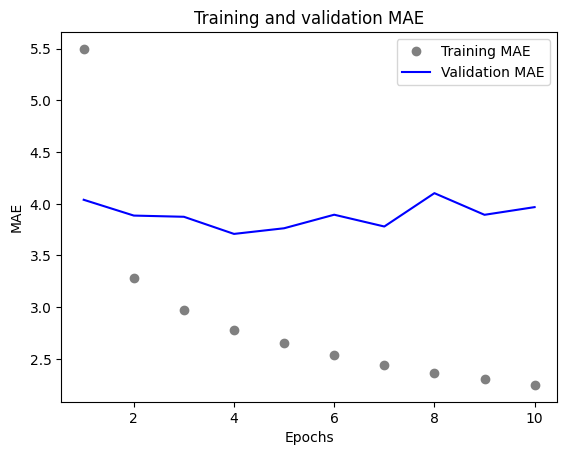

In [39]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")

plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

A Simple GRU (Gated Recurrent Unit)
Model 11

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 110s 131ms/step - loss: 40.9265 - mae: 4.6642 - val_loss: 12.6593 - val_mae: 2.6659
Epoch 2/10
819/819 [==============================] - 109s 132ms/step - loss: 10.7557 - mae: 2.5552 - val_loss: 9.8845 - val_mae: 2.4199
Epoch 3/10
819/819 [==============================] - 126s 154ms/step - loss: 9.9013 - mae: 2.4579 - val_loss: 10.1838 - val_mae: 2.4460
Epoch 4/10
819/819 [==============================] - 127s 155ms/step - loss: 9.4296 - mae: 2.3961 - val_loss: 9.4596 - val_mae: 2.3777
Epoch 5/10
819/819 [==============================] - 110s 134ms/step - loss: 9.1139 - mae: 2.3546 - val_loss: 9.3438 - val_mae: 2.3644
Epoch 6/10
819/819 [==============================] - 129s 157ms/step - loss: 8.8997 - mae: 2.3255 - val_loss: 9.3900 - val_mae: 2.3720
Epoch 7/10
819/819 [==============================] - 108s 132ms/step - loss: 8.7387 - mae: 2.3046 - val_loss: 9.4223 - val_mae: 2.3756
Epoch 8/10
819/819 [========================

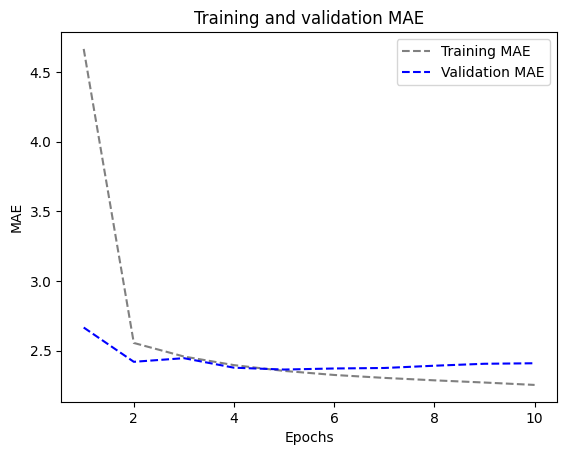

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

 built 11 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: LSTM-Simple

Model 5: LSTM - dropout Regularization

Model 6: Stacked setup with 16 units

Model 7: Stacked setup with 8 units

Model 8: LSTM - dropout-regularized, stacked

Model 8: Bidirectional LSTM

Model 10: 1D Convnets and LSTM togthe
Model 11: A Simple GRU (Gated Recurrent Unit)

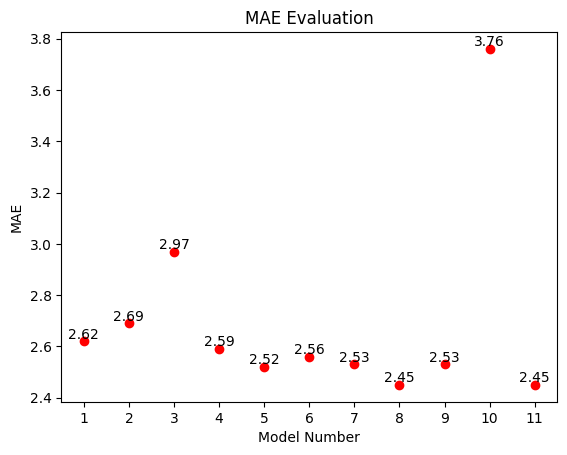

In [43]:
Models = ("1","2","3","4","5","6","7","8","9","10","11")
Mae = (2.62,2.69,2.97,2.59,2.52,2.56,2.53,2.45,2.53,3.76,2.45)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()